In [1]:
import tarfile
import time
import json
import copy
from PIL import Image
import numpy as np
import torch.nn.functional as F
from torch.autograd import Variable
import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torchvision import transforms, models, datasets
import torchvision
import matplotlib.pyplot as plt



from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
# Разархивируем данные
tar = tarfile.open('internship_data.tar.gz')
tar.extractall()
tar.close()

In [3]:
# Предобработка фотографий для "скармливания" модели

data_transforms = transforms.Compose([
    transforms.RandomRotation(45),  # лица в выборке уже под разным углом- введём поворот для лучшего обучения
    transforms.Resize((224,224), interpolation=2), # Приводим к одному размеру
    transforms.Grayscale(num_output_channels=3),  # Приводим к серому цвету- для пола не нужен цвет кожи.
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
])


In [6]:
train_dir = 'internship_data'

In [13]:
# количество одновременных субпроцессов для dataloader
num_workers = 0
# количество экземпляров в батче. ВСего 50000 каждого пола, дадим по 50
batch_size = 56
# Размер валидационной выборки
valid_size = 0.2
# Читаем данные
image_datasets = datasets.ImageFolder(train_dir,   transform=data_transforms)

In [14]:

indices = list(range(len(image_datasets)))

np.random.shuffle(indices)
# Перемешиваем данные для формирования валидационной выборки
split = int(np.floor(valid_size * len(image_datasets)))
train_idx, valid_idx = indices[split:], indices[:split]
print('Длина тренировочной выборки:', len(train_idx))
print('Длина валидационной выборки:', len(valid_idx))

# Тренировочные и валидационные батчи
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


# Формируем пакеты
train_loader = torch.utils.data.DataLoader(image_datasets, batch_size=batch_size,
drop_last= True, sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(image_datasets, batch_size=batch_size, 
drop_last= True, sampler=valid_sampler, num_workers=num_workers)

print('Длина тренировочного dataloader', len(train_loader))
print('Длина валидационного dataloader', len(valid_loader))


Длина тренировочной выборки: 80008
Длина валидационной выборки: 20001
Длина тренировочного dataloader 1428
Длина валидационного dataloader 357


In [15]:
#Классы- мужчина и женщина
class_names = image_datasets.classes
print(class_names)


['female', 'male']


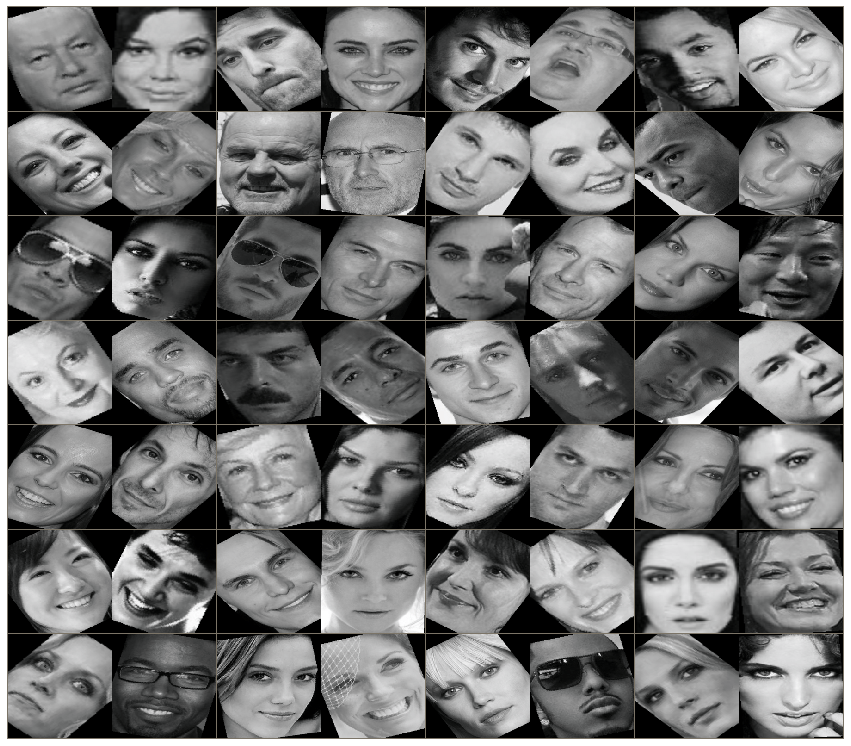

In [16]:
# Посмотрим, что вышло с лицами в одном батче- не стал ничего выдумывать и взял код у девочки с ютуба
def imshow(image):
    if isinstance(image, torch.Tensor):
        image = image.numpy().transpose((1, 2, 0))
    else:
        image = np.array(image).transpose((1, 2, 0))
    # Unnormalize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    plt.imshow(image)
    ax.axis('off') 
        
images, _ = next(iter(train_loader))
out = torchvision.utils.make_grid(images, nrow=8)
imshow(out)

In [17]:
# Взял архитектуру из pytorch- resnet 18
model = models.resnet18(pretrained=True)

In [19]:
features_amount = model.fc.in_features
# В конце изменил вывод на два- мы классифицируем два класса
model.fc = nn.Linear(features_amount, 2)

In [20]:
#GPU включил по-другому ниже
#model.cuda()

In [21]:
# Размораживаем модель - понял, что она разморожена по умолчанию
#for param in model.parameters():
#    param.requires_grad = True

In [27]:
dataloaders_dict = {
    'train': train_loader,
    'val': valid_loader
}

In [30]:
# Взял код с файнтюном с сайта pytorch и чуть-чуть изменил под себя. Не чёрный ящик, конечно, но с серым оттенком
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # У каждой эпохи две фазы
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Тренировка
            else:
                model.eval()   # Оценка

            running_loss = 0.0
            running_corrects = 0

            # Идём по данным
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Обнуляем градиенты параметров
                optimizer.zero_grad()

                
                # forward propagation
                with torch.set_grad_enabled(phase == 'train'):
                    # Получаем выводы модели и значения функции потерь
                    
                    
                    
                    if is_inception and phase == 'train': #
                        # Я не использовал inception, так что эта часть кода  не выполняется
                        outputs, aux_outputs = model(inputs) #
                        loss1 = criterion(outputs, labels) #
                        loss2 = criterion(aux_outputs, labels) #
                        loss = loss1 + 0.4*loss2 #
                    else:
                        outputs = model(inputs) #Зато выполняется вот эта.
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward propagation + оптимизация весов, если модель обучается 
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Загружаем лучшие веса
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [31]:
# Использовал стохастический градиентный спуск
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# Число эпох
num_epochs=5

In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [36]:
#Функция потерь- кросс-энтропия
criterion = nn.CrossEntropyLoss()

# Обучение
model_ft, hist = train_model(model, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=False)

Epoch 0/4
----------
train Loss: 0.1236 Acc: 0.7489
val Loss: 0.0188 Acc: 0.1929

Epoch 1/4
----------
train Loss: 0.0754 Acc: 0.7709
val Loss: 0.0162 Acc: 0.1938

Epoch 2/4
----------
train Loss: 0.0643 Acc: 0.7754
val Loss: 0.0144 Acc: 0.1947

Epoch 3/4
----------
train Loss: 0.0586 Acc: 0.7774
val Loss: 0.0140 Acc: 0.1947

Epoch 4/4
----------
train Loss: 0.0513 Acc: 0.7809
val Loss: 0.0142 Acc: 0.1948

Training complete in 71m 51s
Best val Acc: 0.194842


In [42]:
print('Действительное значение на валидационной выборке {:2f}'.format(0.194842*1424/357))

Действительное значение на валидационной выборке 0.777185


In [48]:
print("Параметры модели:")
for param_tensor in model_ft.state_dict():
    print(param_tensor, "\t", model_ft.state_dict()[param_tensor].size())

Параметры модели:
conv1.weight 	 torch.Size([64, 3, 7, 7])
bn1.weight 	 torch.Size([64])
bn1.bias 	 torch.Size([64])
bn1.running_mean 	 torch.Size([64])
bn1.running_var 	 torch.Size([64])
bn1.num_batches_tracked 	 torch.Size([])
layer1.0.conv1.weight 	 torch.Size([64, 64, 3, 3])
layer1.0.bn1.weight 	 torch.Size([64])
layer1.0.bn1.bias 	 torch.Size([64])
layer1.0.bn1.running_mean 	 torch.Size([64])
layer1.0.bn1.running_var 	 torch.Size([64])
layer1.0.bn1.num_batches_tracked 	 torch.Size([])
layer1.0.conv2.weight 	 torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight 	 torch.Size([64])
layer1.0.bn2.bias 	 torch.Size([64])
layer1.0.bn2.running_mean 	 torch.Size([64])
layer1.0.bn2.running_var 	 torch.Size([64])
layer1.0.bn2.num_batches_tracked 	 torch.Size([])
layer1.1.conv1.weight 	 torch.Size([64, 64, 3, 3])
layer1.1.bn1.weight 	 torch.Size([64])
layer1.1.bn1.bias 	 torch.Size([64])
layer1.1.bn1.running_mean 	 torch.Size([64])
layer1.1.bn1.running_var 	 torch.Size([64])
layer1.1.bn1.num_batche

In [47]:
#Сохраняем модель

torch.save(model_ft, 'saved_model')